In [97]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(pdftools)
library(ggpubr)

In [2]:
selected_sims_chr12 = c("8MF0I020MWGI6N41PH", 
"RNX4L54J663QN2SY5X", "UTJG9R531BVSR6UA41", "CR1UIIF8NRSPZ94LGF",
"SUI6SNW0AFZ3SSL9SJ", "4GROMS6FHMNW5X9L72", "HC27BSIEQBYZJHHUQV",
"OLFRORNB6W0091FLBD", "HVD283AEPBL88J4NUN", "DFFB9J9GYC00WIFTAQ")

In [3]:
win_size = 1000000
chroms= c("chr12")
win_len = -1
padding = 0
rescf = 1
prop_acc=0.4

In [4]:
sinfo_path = "../../output/sims_info.tsv"
sinfoh_path = "../../output/header_sims_info.tsv"
data_path=paste0("../../output/greatapes-diversity-data/all_pidxy_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all.tsv")

In [5]:
widths = c(100, 125, 100)
heights = c(25, 25, 35)


In [6]:
sims_path = "../../output/sims_results/"
varmut_sims_path = "../../output/varmut/sims_results/"

In [7]:
# loading sims info table
sinfo = read.table(sinfo_path, sep="\t", fill=TRUE)
h = read.table(sinfoh_path, sep="\t", header=TRUE)
cnames = colnames(h)
if (length(sinfo) == length(h)+1) {
    cnames = c(cnames, "poscoefdecayeps")
}
colnames(sinfo) = cnames

In [8]:
#diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "rescf", "win_len", "padding", "chr")
diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "poscoefdecayeps", "rescf", "win_len", "padding", "chr")

In [9]:
wsize_str = paste0("win-size_",as.integer(win_size))

In [10]:
sims_folders = paste0(sims_path,list.files(sims_path)[grep(wsize_str, list.files(sims_path))])

In [11]:
varmut_sims_folders = paste0(varmut_sims_path,list.files(varmut_sims_path)[grep(wsize_str, list.files(varmut_sims_path))])

In [12]:
sims_folders = c(sims_folders, varmut_sims_folders)

In [13]:
simresults = as.data.frame(do.call(rbind, lapply(X = sims_folders, function(x) unlist(meta_from_fname(x,prop=prop_acc,suffix="$")))), stringsAsFactors =FALSE)

[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"


In [14]:
#sims_folders

In [15]:
simresults$folderpath = sims_folders

In [16]:
sinfo$posrate = round(sinfo$posrate, digits=15)
sinfo$delrate = round(sinfo$delrate, digits=15)

In [17]:
tmp = unique(sinfo[sinfo$sup_rand_id %in% simresults$sup_rand_id,c(diff_cols,"sup_rand_id")])

In [18]:
#sinfo[sinfo$sup_rand_id=="O814WK8MN3UOF27JIR",]["rand_id"]

In [19]:
simresults = left_join(simresults, tmp)

Joining, by = "sup_rand_id"



In [20]:
colnames(simresults)

[1] "win_size"        "sup_rand_id"     "rep"             "sample_size"    
 [5] "spaced_desc"     "desc"            "prop"            "is_ga_data"     
 [9] "sigma"           "state"           "folderpath"      "delrate"        
[13] "delcoef"         "posrate"         "poscoef"         "mu"             
[17] "poscoefdecayeps" "rescf"           "win_len"         "padding"        
[21] "chr"

In [21]:
sinfo[sinfo$sup_rand_id=="HC27BSIEQBYZJHHUQV","rand_id"]

[1] 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R
 [5] 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R
 [9] 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R
[13] 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R
[17] 370AE9Z4DTPI14R 370AE9Z4DTPI14R 370AE9Z4DTPI14R
1151 Levels: 00D0SVUMHGNHT6S 012WJAJIO267II6 02KG161LRK07FI2 ... ZYUHC7KP4I47LTT

In [22]:
nrow(simresults)

[1] 421

In [23]:
simresults = simresults[simresults$win_len==win_len & simresults$padding == padding & simresults$rescf==1 & as.numeric(simresults$win_size) == win_size & simresults$chr %in% chroms,]

In [24]:
simresults[is.na(simresults$poscoefdecayeps),]$poscoefdecayeps = 0

In [25]:
simresults$selregime = ifelse(simresults$posrate<1e-16,ifelse(simresults$delrate<1e-16, ifelse(simresults$sigma==0, "neutral", "varmut"), "del_only"), ifelse(simresults$delrate<1e-16, "pos_only", "both"))

In [26]:
simresults$seldesc = apply(
    simresults,
    1,
    function(x) paste("mu-D=", x["delrate"],
                      " mu-B=", x["posrate"],
                      ifelse(x['selregime'] %in% c("del_only", "both"), paste0("\ncoef-D=", x["delcoef"]), ""),
                      ifelse(x['selregime'] %in% c("both", "pos_only"), paste0("\ncoef-B=", x["poscoef"], " decay-B=", x["poscoefdecayeps"]), ""),
                      ifelse(x["selregime"]=="varmut", paste0(" mut-sd=", x['sigma']),""),
                      "\n(", x["sup_rand_id"], ")", 
                      sep=""))
simresults$seldesc_norandid = apply(
    simresults,
    1,
    function(x) paste("mu-D=", x["delrate"],
                      " mu-B=", x["posrate"],
                      ifelse(x['selregime'] %in% c("del_only", "both"), paste0("\ncoef-D=", x["delcoef"]), ""),
                      ifelse(x['selregime'] %in% c("both", "pos_only"), paste0("\ncoef-B=", x["poscoef"], " decay-B=", x["poscoefdecayeps"]), ""),
                      ifelse(x["selregime"]=="varmut", paste0(" mut-sd=", x['sigma']),""), 
                      sep=""))

In [27]:
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "\n", " ")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, " \\(.+$", "")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, " coef-.+$", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu-D=0.0e\\+00", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu-B=0e\\+00", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "data", "Data")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu", "\\u03bc")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "-D", "\\u2099")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "-B", "\\u209a")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, "\\u03bct", "\\u03bc")

In [28]:
simresults$sigma = as.numeric(simresults$sigma)

In [29]:
tmp = simresults
ordered = c("neutral", "del_only", "pos_only", "both", "varmut")
classes = unique(tmp$selregime)
tmp$selregime = factor(tmp$selregime, levels=classes[order(match(classes,ordered))])
tmp = tmp[
  with(tmp, order(selregime,posrate,-poscoefdecayeps,delrate,poscoef,delcoef,sigma)),
]

In [30]:
tmp$selregime == "varmut"

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

In [31]:
selected_sims_chr12

[1] "8MF0I020MWGI6N41PH" "RNX4L54J663QN2SY5X" "UTJG9R531BVSR6UA41"
 [4] "CR1UIIF8NRSPZ94LGF" "SUI6SNW0AFZ3SSL9SJ" "4GROMS6FHMNW5X9L72"
 [7] "HC27BSIEQBYZJHHUQV" "OLFRORNB6W0091FLBD" "HVD283AEPBL88J4NUN"
[10] "DFFB9J9GYC00WIFTAQ"

In [32]:
## FINAL FIG PANEL SELECTION

In [33]:
tmp2 = tmp[tmp$sup_rand_id %in% selected_sims_chr12 & tmp$sigma == 0.0, ]
tmp2[tmp2$seldesc_norandid==' ',]$seldesc_norandid="Neutral"
#tmp2 = tmp2[tmp2$seldesc_norandid!="Neutral",]


In [34]:
data_row = simresults[1,]
data_row$sup_rand_id="data"
data_row$spaced_desc="data"
data_row$desc="data"
data_row$is_ga_data=TRUE
data_row$sigma=0
data_row$state="all"
data_row$folderpath = data_path
data_row$delrate=0
data_row$delcoef=0
data_row$posrate=0
data_row$poscoef=0
data_row$mu=0
data_row$poscoefdecayeps=0
data_row$rescf=0
data_row$win_len=0
data_row$padding=0
data_row$selregime="data"
data_row$seldesc="data"
data_row$chr="chr12"

In [35]:
pref = "pidxy-filtered-withmetadata"
list_of_pidxys = apply(tmp2,1, function(x) read.table(paste0(x["folderpath"],
                                             "/",pref, "_",x["desc"],".tsv"), sep="\t", header=TRUE))

In [36]:
tmp2 = rbind(tmp2,data_row)

In [37]:
data_df = read.table(data_row$folderpath,sep="\t",header=TRUE)
data_df = data_df[data_df$chr %in% chroms,] # getting only chroms of interest
data_df = data_df[data_df$stat %in% c("pi", "dxy"),]

In [38]:
data_df = data_df %>%
    mutate(spp1 = str_replace(spp1, "_", "-"), spp2=str_replace(spp2,"_","-")) %>%
    mutate(spp1 = str_replace(spp1, "homo", "humans"), spp2=str_replace(spp2,"homo","humans"))
data_df$start = data_df$start-1

In [39]:
data_df = data_df[data_df$end < 132000001,]

In [40]:
list_of_pidxys = append(list_of_pidxys,list(data_df))
names(list_of_pidxys) = tmp2$desc


In [41]:
pidxys = bind_rows(list_of_pidxys, .id="id")
pidxys = left_join(pidxys, tmp2, by=c("id"="desc"))


In [42]:
wide_pidxys = pidxys[,c("id","spp1", "spp2", "selregime", "seldesc", "value","stat", "chr.x", "start", "end")] %>% 
    pivot_wider(id_cols=c("id","selregime","seldesc"),
                names_from=c("spp1", "spp2","chr.x","start"),
                values_from=c("value"),
               names_sep="__")
wide_pidxys = wide_pidxys %>% select_if(~ !any(is.na(.)))

In [114]:
sel_srid = c("data", "8MF0I020MWGI6N41PH", "CR1UIIF8NRSPZ94LGF", "HVD283AEPBL88J4NUN")
spp_subset=c("humans", "bonobo", "bornean-orangutan", "western-gorilla", "central-chimp")
lvs = c("Data","Neutral", "Both", "Deleterious")
lvs_reorder = c("Data","Neutral", "Deleterious", "Both")

In [118]:
means = pidxys %>% group_by(spp1,spp2,stat,selregime,seldesc, sup_rand_id) %>% summarize(mean_value=mean(value, na.rm=T))
means = means[means$spp1 %in% spp_subset & means$spp2 %in% spp_subset,]
means$combo = paste(means$spp1,means$spp2, sep="_")
stds = pidxys %>%
    group_by(id,spp1,spp2,stat,selregime,seldesc,sup_rand_id) %>% summarize(std=sd(value, na.rm=T))# %>% group_by(spp1,spp2,stat,selregime,sup_rand_id,seldesc)%>% summarize(meansd=mean(std)) 
stds$combo = paste(stds$spp1,stds$spp2, sep="_")
stds = stds[stds$spp1 %in% spp_subset & stds$spp2 %in% spp_subset,]



`summarise()` has grouped output by 'spp1', 'spp2', 'stat', 'selregime', 'seldesc'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'id', 'spp1', 'spp2', 'stat', 'selregime', 'seldesc'. You can override using the `.groups` argument.



In [119]:
options(repr.plot.width=10, repr.plot.height=8)
df = means[means$sup_rand_id %in% sel_srid & means$spp1 == means$spp2,]
df$seldesc = factor(df$seldesc)
levels(df$seldesc) = lvs
df$seldesc = factor(df$seldesc, levels=lvs_reorder)
mean_div = ggplot(data=df,
       aes(y=mean_value, x=seldesc, col=spp1, group=c(spp1))) +
            geom_point() +
            geom_line() +
            theme_bw(base_size=12) +
            labs(x="Regime", y="Mean Diversity", col="Species")

In [120]:
df = stds[stds$sup_rand_id %in% sel_srid & stds$spp1 == stds$spp2,]
df$seldesc = factor(df$seldesc)
levels(df$seldesc) = lvs
df$seldesc = factor(df$seldesc, levels=lvs_reorder)

In [121]:
options(repr.plot.width=10, repr.plot.height=8)
sd_div = ggplot(data=df,
       aes(y=std, x=seldesc, col=spp1, group=c(spp1))) +
            geom_point() +
            geom_line() +
            theme_bw(base_size=12) +
            labs(x="Regime", y="SD Diversity", col="Species")

In [122]:
options(repr.plot.width=20, repr.plot.height=8)
df = means[means$sup_rand_id %in% sel_srid & means$spp1 != means$spp2,]
df$seldesc = factor(df$seldesc)
levels(df$seldesc) = lvs
df$seldesc = factor(df$seldesc, levels=lvs_reorder)
mean_dxy = ggplot(data=df,
       aes(y=mean_value, x=seldesc, col=combo, group=c(combo))) +
            geom_point() +
            geom_line() +
            theme_bw(base_size=12) +
            labs(x="Regime", y="Mean Divergence", col="Species combo")

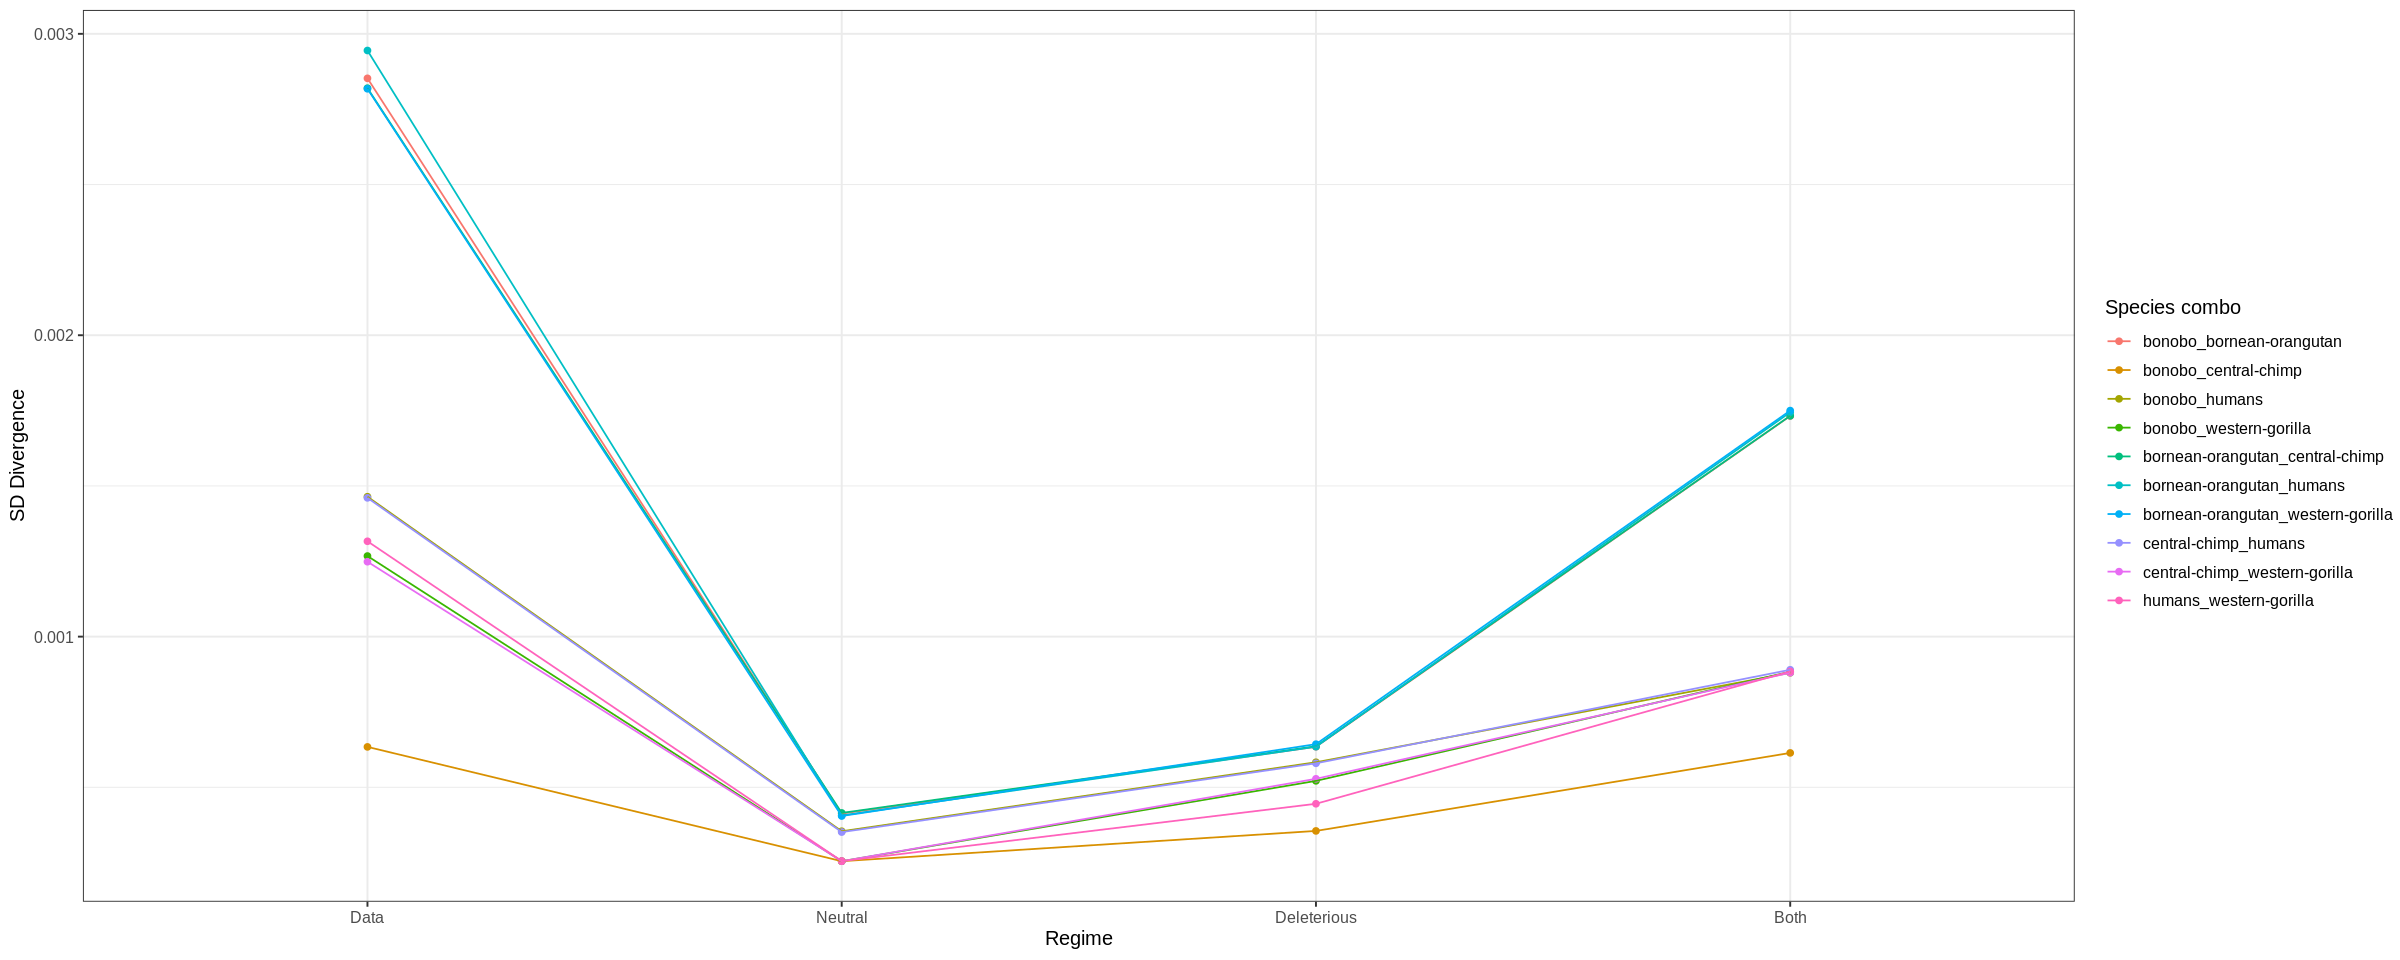

In [123]:
options(repr.plot.width=20, repr.plot.height=8)
df = stds[stds$sup_rand_id %in% sel_srid & stds$spp1 != stds$spp2,]
df$seldesc = factor(df$seldesc)
levels(df$seldesc) = lvs
df$seldesc = factor(df$seldesc, levels=lvs_reorder)
sd_dxy = ggplot(data=df,
       aes(y=std, x=seldesc, col=combo, group=c(combo))) +
            geom_point() +
            geom_line() +
            theme_bw(base_size=12) +
            labs(x="Regime", y="SD Divergence", col="Species combo")
sd_dxy

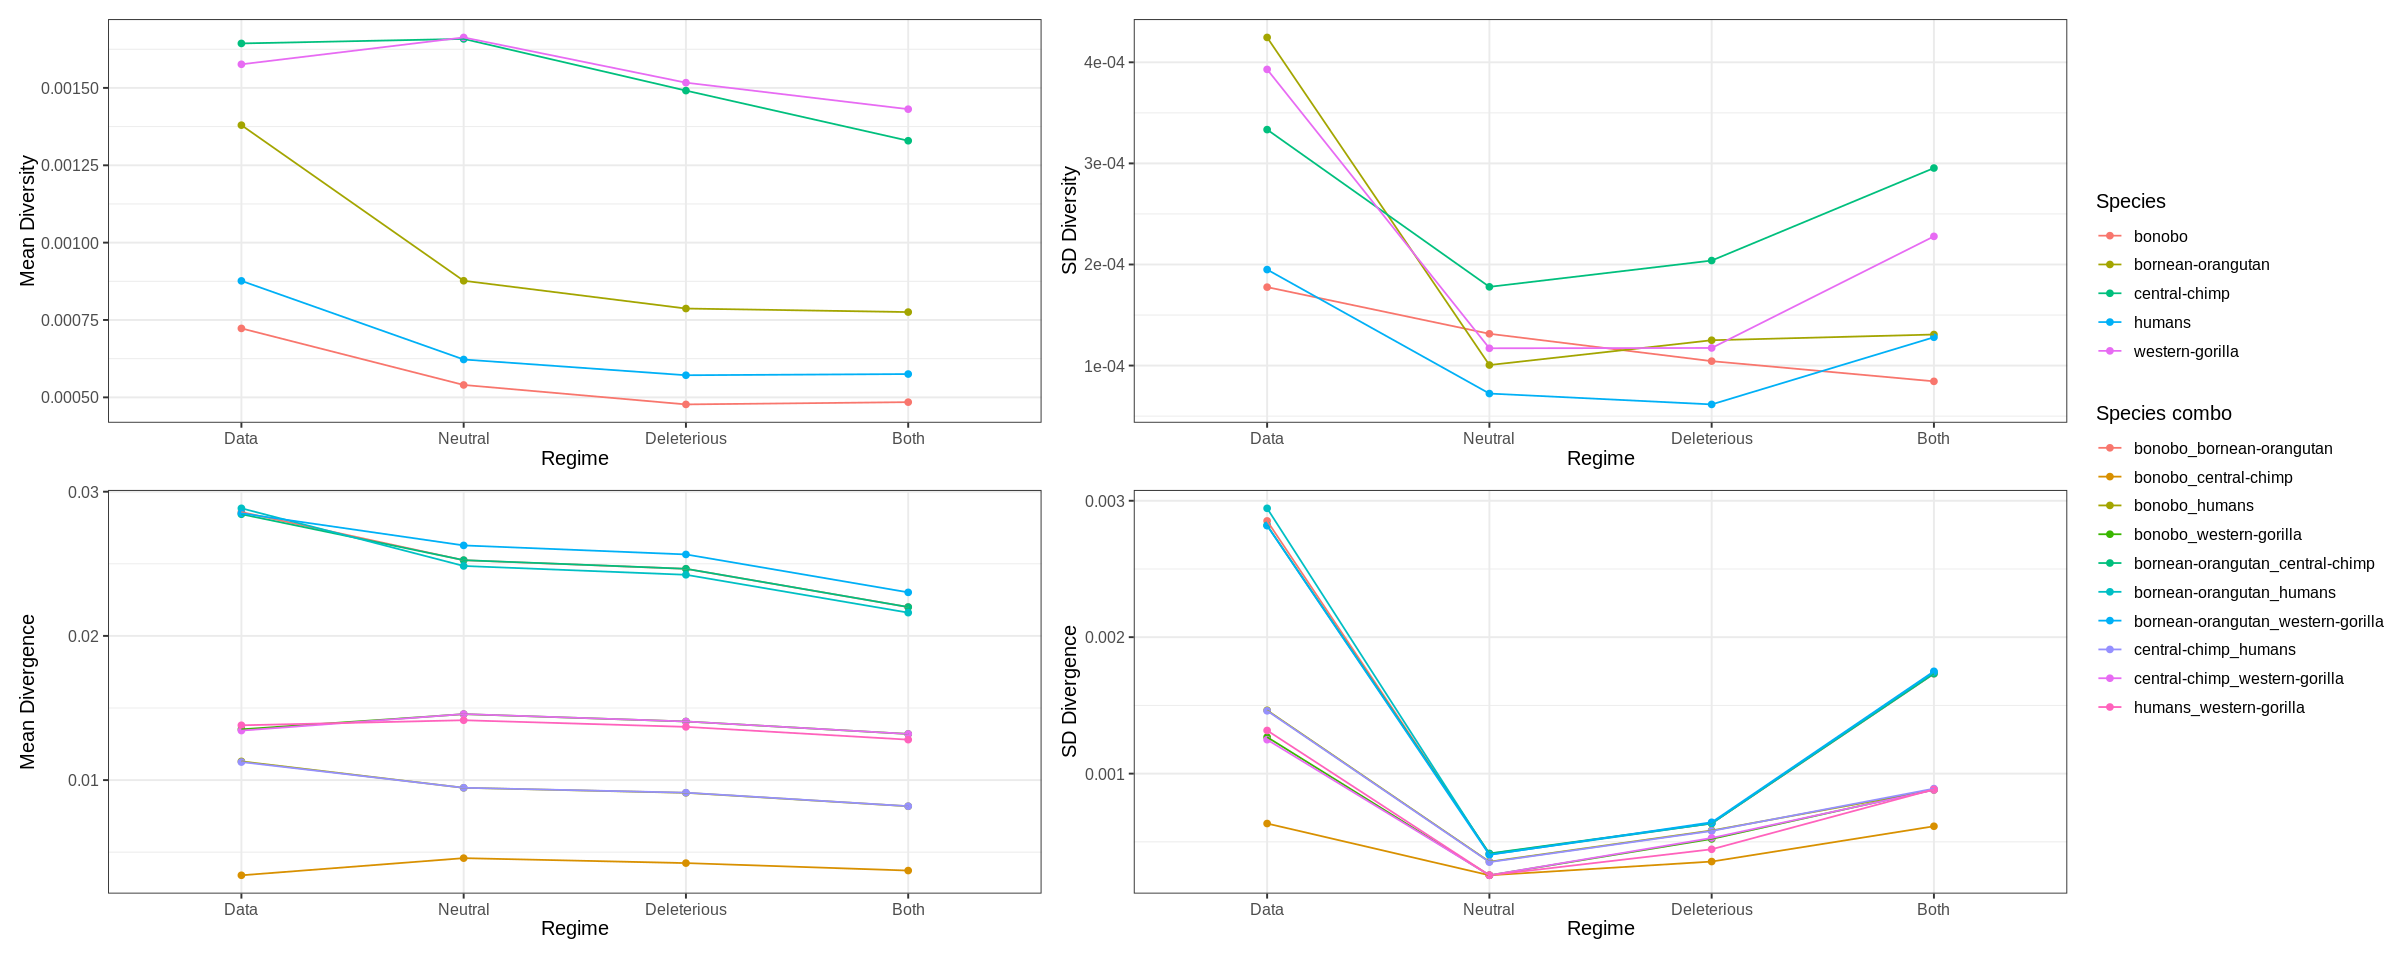

In [124]:
options(repr.plot.width=20, repr.plot.height=8)

(mean_div+sd_div) / (mean_dxy+sd_dxy) + plot_layout(guides = 'collect')
ggsave("../../output/final_figs/data_and_sims_summaries.pdf", width=8.5, height=5, device=cairo_pdf, scale=2)

In [125]:
sub = pidxys[pidxys$spp1==pidxys$spp2 & pidxys$sup_rand_id %in% sel_srid & pidxys$spp1 %in% spp_subset & pidxys$spp1 %in% spp_subset,]
wide = sub %>%
    pivot_wider(id_cols=c("start","spp1"),
                names_from=c("selregime"),
                values_from=c("value"),
               names_sep="__")
#wide_pidxys = wide_pidxys %>% select_if(~ !any(is.na(.)))

In [126]:
cor.test(wide$both, wide$data, na.action=na.omit, method="spearman")

Warning message in cor.test.default(wide$both, wide$data, na.action = na.omit, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  wide$both and wide$data
S = 10932794, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
    rho 
0.76114 


Warning message:
"Removed 30 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 30 rows containing missing values (geom_point)."
Warning message:
"Removed 30 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 30 rows containing missing values (geom_point)."


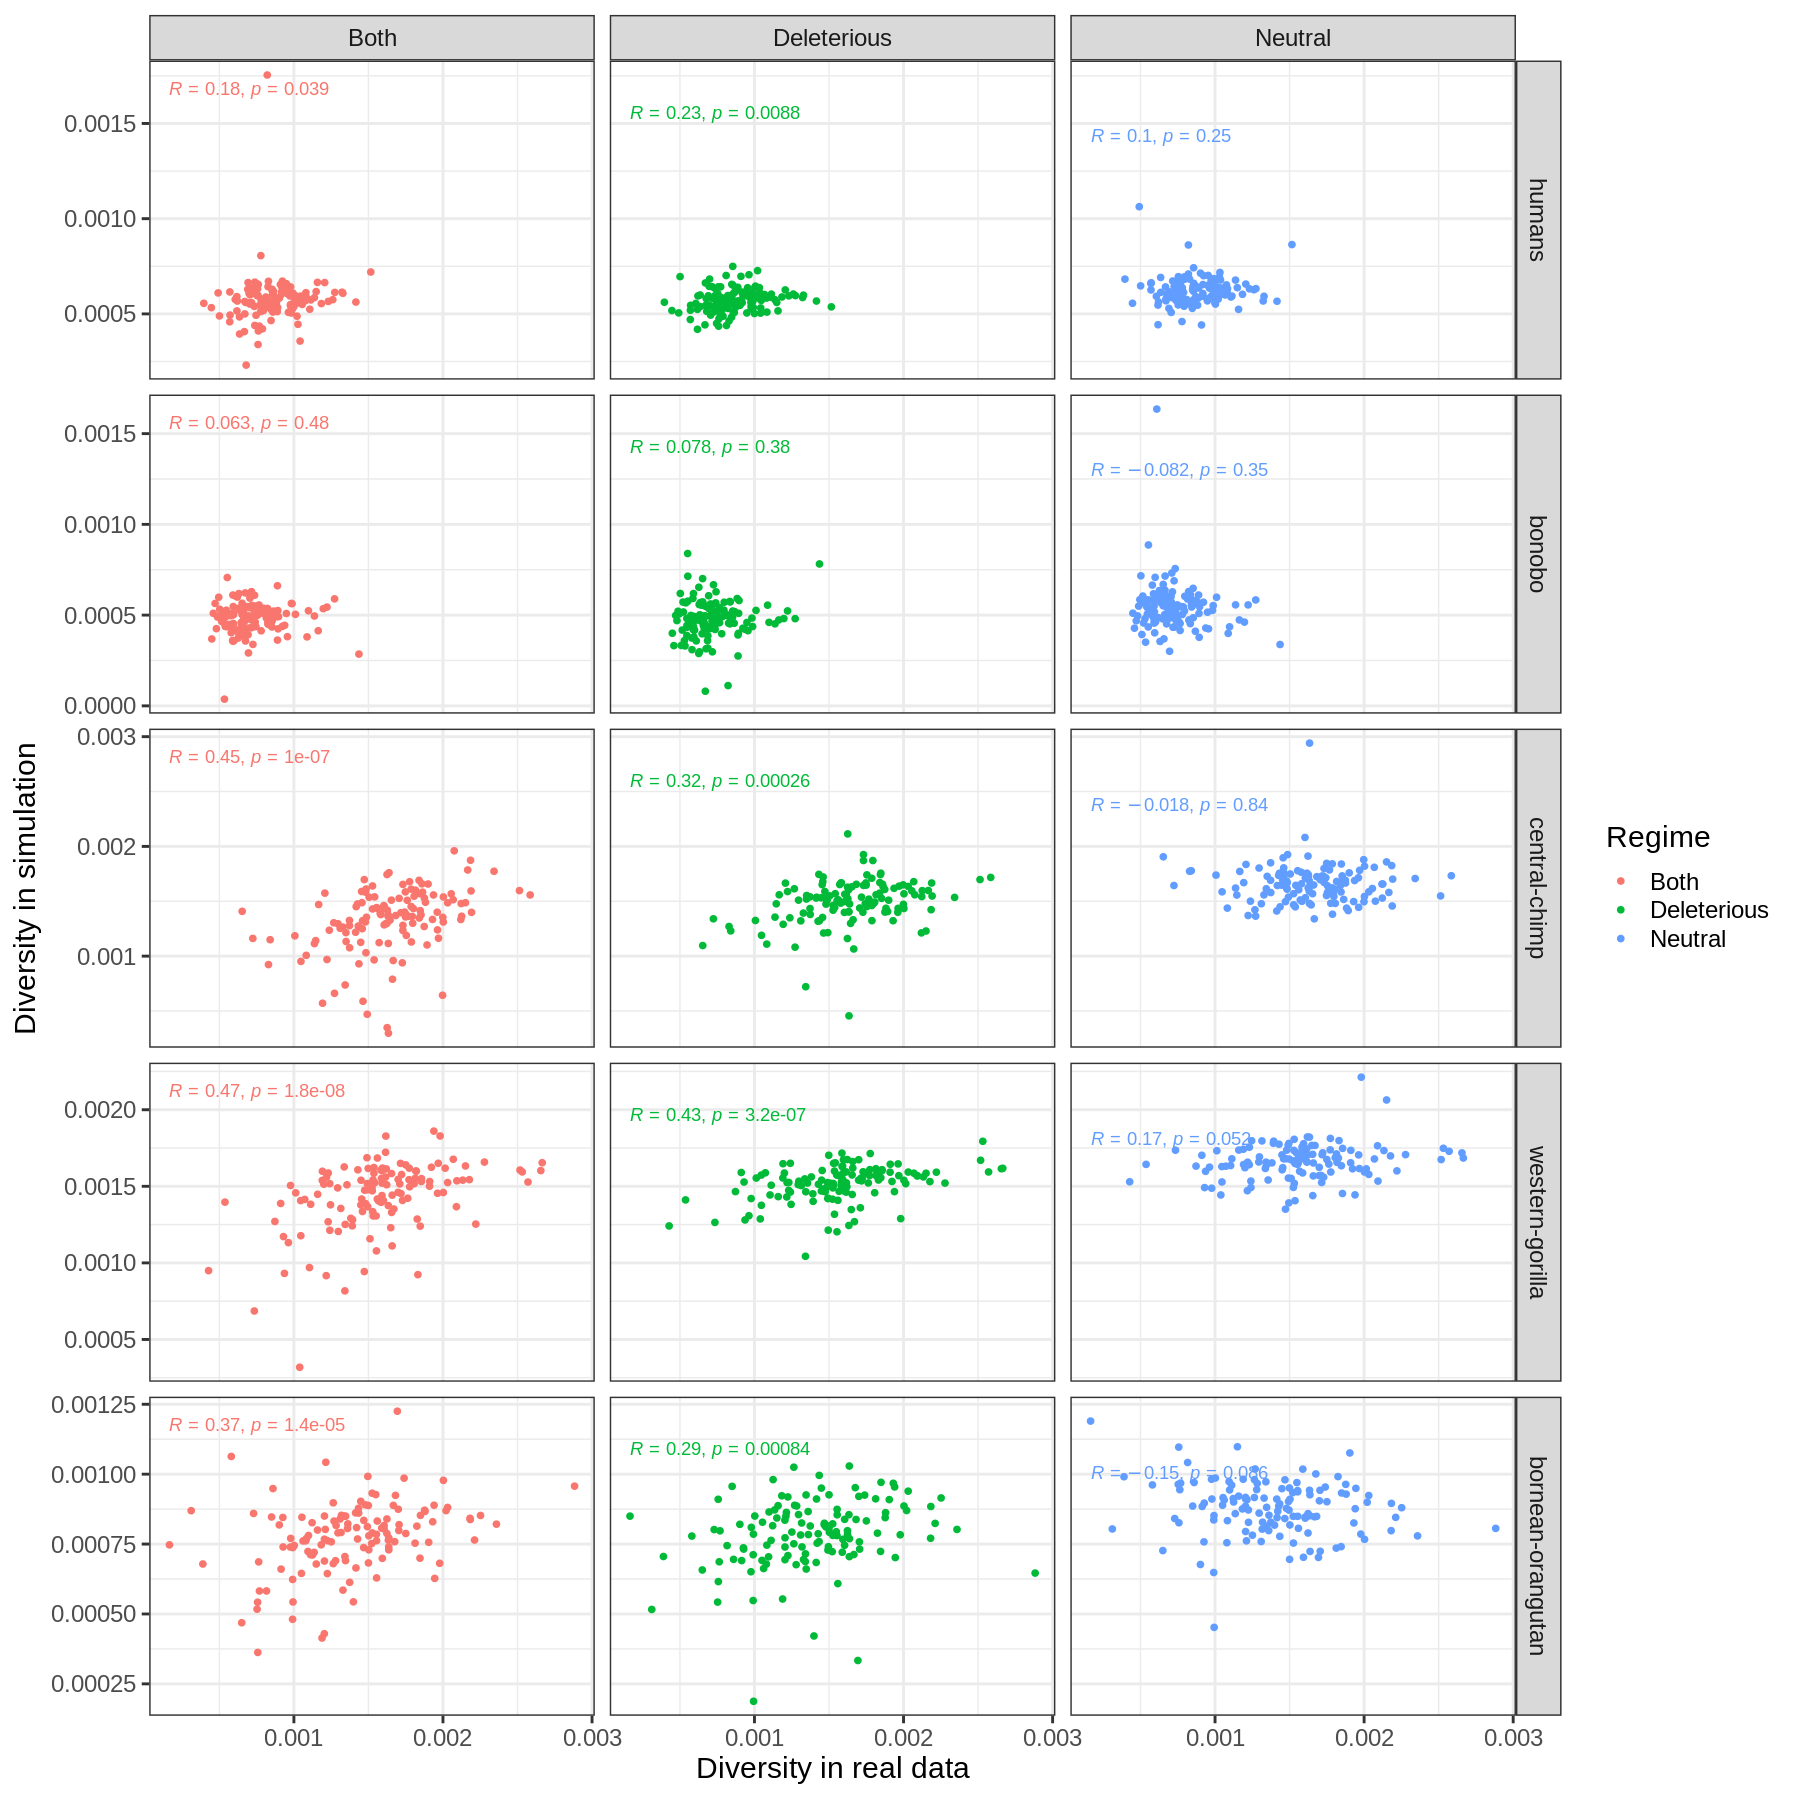

In [144]:
options(repr.plot.width=15, repr.plot.height=15)

wide %>% pivot_longer(!c(start,data,spp1)) %>%
    mutate(name = recode(name, "both" = "Both", "del_only"="Deleterious","neutral"="Neutral")) %>%
    mutate(spp1=fct_relevel(spp1,c("humans","bonobo","central-chimp","western-gorilla","bornean-orangutan"))) %>%
    ggplot(aes(x=data, y=value, col=name)) + 
    geom_point() + 
    facet_grid(spp1~name, scales="free") + 
    theme_bw(base_size=18) + 
    stat_cor(method="spearman",show.legend = FALSE) +
    labs(x="Diversity in real data", y = "Diversity in simulation", col="Regime")
ggsave("../../output/final_figs/corrs_between_data_and_sims.pdf", width=7, height=8.5, device=cairo_pdf, scale=2)